# Examples of model output

This notebook demonstrates some examples of how to visualize the model outputs

You can also take a look at [xarray's documentation](https://docs.xarray.dev/en/stable/user-guide/plotting.html) for more examples of plotting xarray datasets

The main 2d output files are: 
- ds_canopy.nc: Dataset with the canopy variables:
    - S_kx: [unitless] Cavitation of stem xylem, given by eqn S.79 in Silva et al 2022
    - trans_2d: [m3H2O m-2crown_projection m-1stem s-1] Transpiration
    - H: [MPa] Water potential
    - K: [m s-1] Hydraulic conductivity
    - Capac: [Pa-1] Capacitance
- ds_root.nc: Dataset with the root variables:
    - Kr_sink [1/sPa]: Effective root radial conductivity
    - S_kr [unitless]: Cavitation of root xylem, given by eqn S.77 in Silva et al 2022
    - S_sink [unitless]: Feddes root water uptake stress function, given by equations S.73, 74 and 75 in Silva et al 2022
    - EVsink_ts [m3H2O m-2ground m-1depth s-1]: Root water uptake
    - H: [MPa] Water potential
    - K: [m s-1] Hydraulic conductivity
    - Capac: [Pa-1] Capacitance
- ds_soil.nc: Dataset with the soil variables:
    - THETA: [m3 m-3] Volumetric water content
    - H: [MPa] Water potential
    - K: [m s-1] Hydraulic conductivity
    - Capac: [Pa-1] Capacitance
- sapflux.nc: Dataset with sapflux and aboveground water storage
    - sapflux: [m3 s-1] Tree-level sap flux
    - storage: [m3] Total aboveground water storage
    - delta_s: [m3] Change in aboveground water storage from the previous timestep
- ds_all.nc: Dataset with H, Capac, and K concatenated for the entire z array
(these variables are also written in ds_canopy, ds_root, and ds_soil, so in most
cases it is easier to use those datasets instead)



In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import pandas as pd

from fetch3.helpers import load_model_outputs

from pathlib import Path
%matplotlib widget

## Loading the data

Specify the directory containing the model output. 

**Make sure you change this to the correct directory for your output.**
If you're using outputs from an optimization, make sure you give the directory 
for a specific trial, not the directory for the entire optimization experiment.
This directory should contain the .nc output files. 

In [2]:
model_output_dir = "/Users/jmissik/Desktop/repos/fetch3_nhl/output/UMBS_test_Ameriflux_M8_20220519T120204/000049"

Load the input met data. Again, make sure to change this to the correct file path 
for your computer. 

In [3]:
filein = "/Users/jmissik/Desktop/repos/fetch3_nhl/data/UMBS_flux_2011.csv"
met = pd.read_csv(filein, parse_dates=['Timestamp'])
met = met.set_index('Timestamp')

There is a convenience function to load a set of the model output all at once: 

In [4]:
dsall, canopy, soil, roots, sapflux, nhl = load_model_outputs(model_output_dir)

Alternatively, you can load a model output file yourself, for example: 

In [5]:
# filein can be a pathlib Path, or simply a string of the file path
filein = Path(model_output_dir) / "sapflux.nc"
sapflux = xr.load_dataset(filein)

In [6]:
#NHL transpiration (transpiration before reduction from xylem water potential was applied)
filein = Path(model_output_dir) / 'nhl_out.nc'
nhl = xr.load_dataset(filein)

The netcdf output files are loaded as xarray dataset objects. You can easily view the variables in the dataset,
coordinates (in this case, z and time), and metadata:

In [7]:
canopy

<xarray.Dataset>
Dimensions:   (time: 98, z: 175)
Coordinates:
  * time      (time) datetime64[ns] 2011-07-06 ... 2011-07-08T00:30:00
  * z         (z) float64 5.1 5.2 5.3 5.4 5.5 5.6 ... 22.1 22.2 22.3 22.4 22.5
Data variables:
    H         (time, z) float64 -0.08648 -0.0873 -0.08811 ... -0.26 -0.261
    K         (time, z) float64 0.0 0.0 0.0 ... 1.601e-13 1.601e-13 1.601e-13
    Capac     (time, z) float64 0.0 0.0 0.0 ... 4.105e-12 4.105e-12 4.104e-12
    S_kx      (time, z) float64 0.0 0.0 0.0 0.0 ... 0.923 0.9229 0.9227 0.9226
    trans_2d  (time, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [8]:
# To retrieve attributes of a variable directly: 
canopy.H.attrs

{'description': 'Water potential', 'units': 'MPa'}

## Plotting one depth/height of a variable

For the outputs that have two dimensions (z and time), you can select a slice of z. 

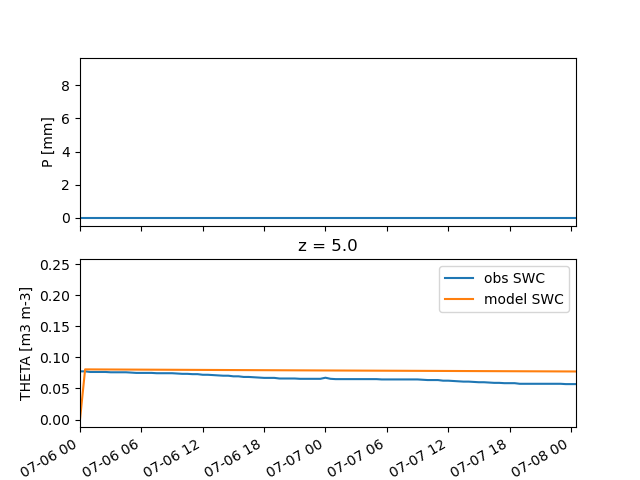

In [9]:
# Plot observed precipitation and soil moisture, and model soil moisture

# Depth to plot
# Make sure this value is in the z index 
depth = 5.0

fig, axs = plt.subplots(2,1, sharex=True)

ax = axs[0]
ax.plot(met.P_F)
ax.set_ylabel ('P [mm]')

ax = axs[1]
ax.plot(met.SWC_m3m3)

# plot model SWC
soil.THETA.sel(z=depth).plot(x='time')

# #select just the time range of the model output 
ax.set_xlim(soil.time.min(), soil.time.max())
ax.legend(['obs SWC', 'model SWC'])

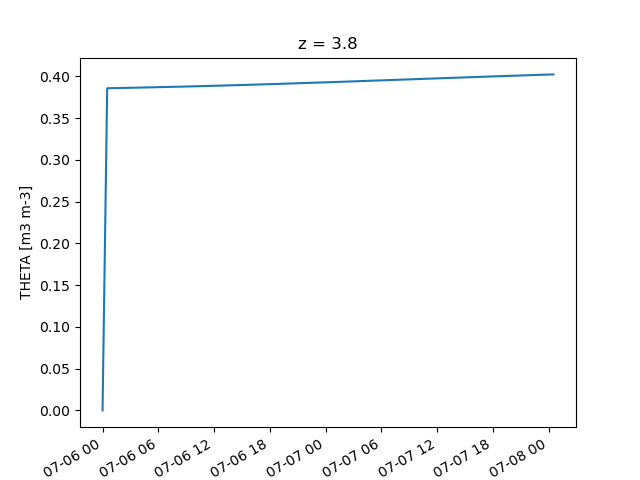

In [10]:
# Plot soil moisture at one depth
depth = 3.8

fig, axs = plt.subplots()

ax = axs

soil.THETA.sel(z=depth).plot(x='time')

## Plotting 2d outputs

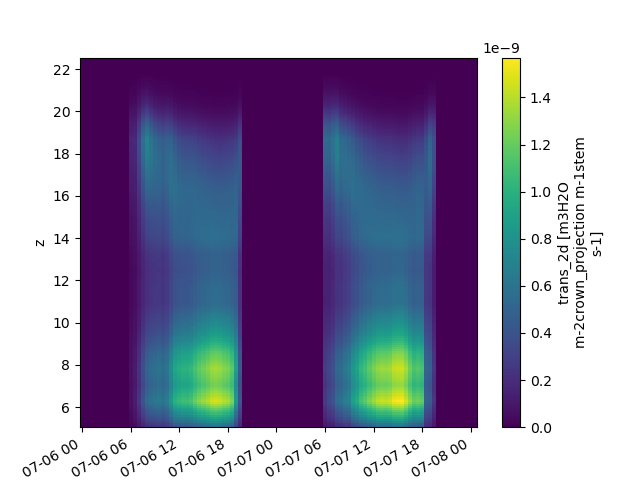

In [11]:
# Transpiration
fig, axs = plt.subplots()
ax = axs
canopy.trans_2d.plot(x='time')

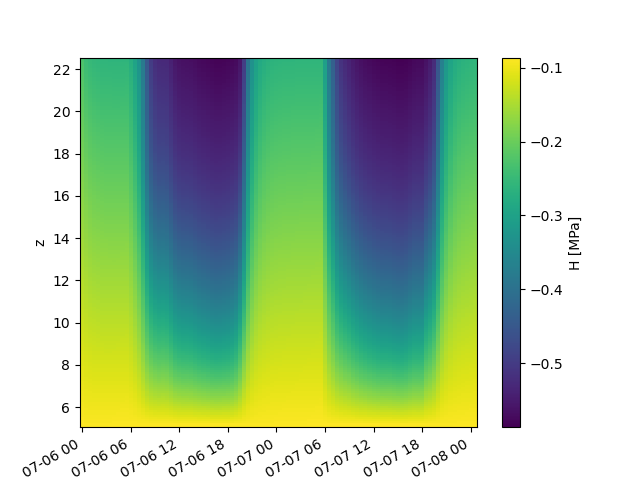

In [12]:
# Water potential (canopy)
fig, axs = plt.subplots()
ax = axs
canopy.H.plot(x='time')

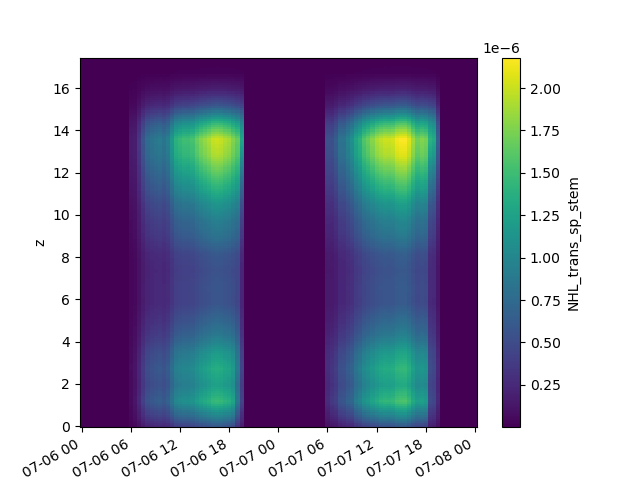

In [13]:
fig, axs = plt.subplots()

ax = axs

nhl.NHL_trans_sp_stem.plot(x='time')

## Vertically integrated transpiration

In [14]:
# Calculate vertically integrated transpiration
dz = canopy.z[1] - canopy.z[0]
trans_tot = (canopy.trans_2d * dz).sum(dim='z')
nhl_tot = (nhl.NHL_trans_sp_stem * dz).sum(dim='z')

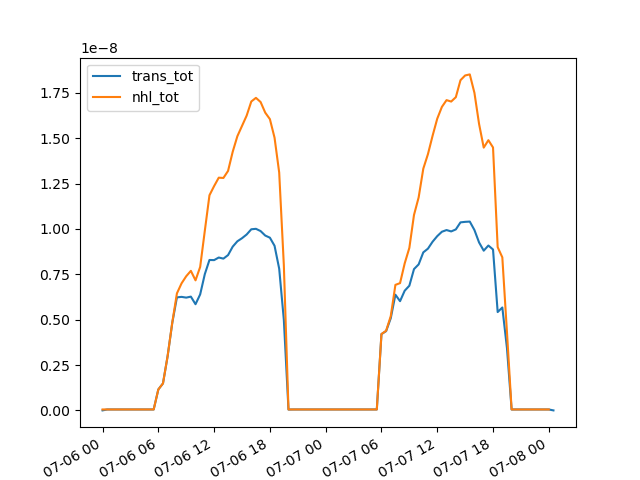

In [15]:
#Plot NHL transpiration and model transpiration

fig, axs = plt.subplots()

ax = axs

trans_tot.plot.line(x='time')
(nhl_tot*(10**-3)).plot.line(x='time') # NHL output was in kg
ax.legend(["trans_tot", "nhl_tot"])

## Sap flux and storage

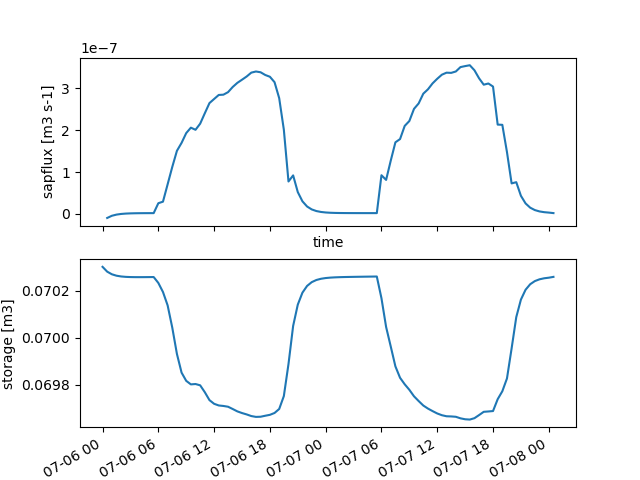

In [16]:
# Plot sapflux and change in storage
fig, axs = plt.subplots(2,1, sharex = True)

ax = axs[0]
sapflux.sapflux.plot.line(x='time', ax=ax)

ax = axs[1]
sapflux.storage.plot.line(x='time', ax=ax)
# ax.legend(["sapflux", "delta S", "storage"])